In [1]:
# --- 1. 导入必要的库并设置项目路径 ---
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
from tqdm import tqdm
from omegaconf import OmegaConf
import torch_geometric.data
import umap
from torch_geometric.nn import global_mean_pool

# 假设本 Notebook 位于项目的 'test/' 目录下
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
print(f"项目根目录已添加到系统路径: {PROJECT_ROOT}")

from src.models.combined_model import CombinedModel
from src.utils import set_seed, get_device, plot_umap_comparison
from src.data_loader import load_gene_graph_data, create_cells_by_day_mapping
from src.losses import CombinedLoss 
from src.evaluate import _get_point_estimate_from_params, _reshape_params_for_loss_or_eval

项目根目录已添加到系统路径: /root/autodl-tmp/scGODE3


In [2]:
# ## 2. 配置
# --- 用户可配置参数 ---

# 指向您的主配置文件
CONFIG_PATH = os.path.join(PROJECT_ROOT, "configs/main_config.yaml")

# 指向您已经训练好的、想要评估的联合模型检查点
CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "results/experiment_stable_start/checkpoints/joint_train_best.pt")

# 定义轨迹预测的起始时间点
START_DAY = 8.25

# --- 可视化参数 ---
NUM_SAMPLES_PER_DAY = 100 # 为每个时间点采样的细胞数量
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1
UMAP_METRIC = 'euclidean'
UMAP_RANDOM_STATE = 42

In [3]:
# ## 3. 加载配置、数据和模型
# --- 加载配置 ---
if not os.path.exists(CONFIG_PATH):
    raise FileNotFoundError(f"配置文件未找到: {CONFIG_PATH}")
config = OmegaConf.load(CONFIG_PATH)

set_seed(config.seed)
device = get_device(config.training_params.device)
print(f"正在使用设备: {device}")

# --- 加载数据 ---
print("正在加载数据...")
actual_data_dir = config.data_params.data_dir
if not os.path.isabs(actual_data_dir):
    actual_data_dir = os.path.join(PROJECT_ROOT, actual_data_dir)
if not os.path.exists(actual_data_dir):
    raise FileNotFoundError(f"数据目录未找到: {actual_data_dir}")
X_all_np, shared_edge_index, shared_edge_weight, gene_names, cell_names, meta_df = \
    load_gene_graph_data(actual_data_dir, config)
cells_by_day_indices = create_cells_by_day_mapping(meta_df, cell_names)
print("数据加载完成。")

# --- 加载模型和损失函数 ---
print(f"正在从检查点加载模型: {CHECKPOINT_PATH}")
if not os.path.exists(CHECKPOINT_PATH):
    raise FileNotFoundError(f"检查点文件未找到: {CHECKPOINT_PATH}")
model = CombinedModel(config)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

state_dict = checkpoint['model_state_dict']
if all(key.startswith('module.') for key in state_dict.keys()):
    print("检查点来自DDP模型，正在移除 'module.' 前缀。")
    state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model.to(device)
model.eval()
print("模型加载完成。")

loss_fn = CombinedLoss(config.loss_weights, config=config, device=device)

# --- 获取模型和数据参数 ---
all_available_days = sorted(meta_df['day_numeric'].dropna().unique())
TARGET_DAYS = [day for day in all_available_days if day > START_DAY]
if not TARGET_DAYS:
    raise ValueError(f"在数据中找不到任何晚于起始日 {START_DAY} 的时间点。")
print(f"自动确定的目标预测日: {TARGET_DAYS}")

is_variational = bool(config.model_params.encoder.get("is_variational", False))
node_type = str(config.model_params.node.get("type", "NeuralODE")).upper()
decoder_distribution = config.model_params.decoder.get("distribution", "gaussian")
num_dist_params = config.model_params.decoder.get("num_dist_params", 2)
num_genes = int(config.model_params.num_genes)

正在使用设备: cuda
正在加载数据...
数据加载完成。
正在从检查点加载模型: /root/autodl-tmp/scGODE3/results/experiment_stable_start/checkpoints/joint_train_best.pt
模型加载完成。
自动确定的目标预测日: [np.float64(8.5), np.float64(8.75), np.float64(9.0), np.float64(9.5), np.float64(10.0), np.float64(10.5), np.float64(11.0), np.float64(11.5), np.float64(12.0), np.float64(12.5), np.float64(13.0), np.float64(13.5), np.float64(14.0), np.float64(14.5), np.float64(15.0), np.float64(15.5), np.float64(16.0), np.float64(16.5), np.float64(17.0), np.float64(17.5), np.float64(18.0)]


/tmp/ipykernel_39182/3095634626.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)


In [4]:
# ## 4. 生成和收集数据与指标
# --- 初始化数据收集容器 ---
real_expressions_for_umap, pred_expressions_for_umap = {}, {}
real_latent_for_umap, pred_latent_for_umap = {}, {}
metrics_per_day = {}
days_for_metrics = []


# --- 准备起始细胞批次 ---
if START_DAY not in cells_by_day_indices or len(cells_by_day_indices[START_DAY]) == 0:
    raise ValueError(f"起始日 {START_DAY} 在数据中没有有效的细胞。")
start_day_indices = np.random.choice(cells_by_day_indices[START_DAY], min(NUM_SAMPLES_PER_DAY, len(cells_by_day_indices[START_DAY])), replace=False)
start_data_list = [torch_geometric.data.Data(x=torch.tensor(X_all_np[i], dtype=torch.float32).unsqueeze(-1), edge_index=shared_edge_index) for i in start_day_indices]
start_batch_pyg = torch_geometric.data.Batch.from_data_list(start_data_list).to(device)

with torch.no_grad():
    # --- 编码初始状态并存储 ---
    z_t0_eff, mu_start, log_var_start, batch_start, pooling_details_start = model.graph_autoencoder.encode(start_batch_pyg, return_pooling_details=True)
    initial_z_for_dynamics = mu_start if is_variational and mu_start is not None else z_t0_eff
    
    real_expressions_for_umap[f"Real Day {START_DAY:.2f}"] = X_all_np[start_day_indices]
    real_latent_for_umap[f"Real Day {START_DAY:.2f}"] = global_mean_pool(initial_z_for_dynamics, batch_start).detach().cpu().numpy()
    pred_latent_for_umap[f"Start/Pred Day {START_DAY:.2f}"] = global_mean_pool(initial_z_for_dynamics, batch_start).detach().cpu().numpy()

    # --- 迭代预测并收集结果 ---
    for target_t in tqdm(TARGET_DAYS, desc="预测轨迹并计算指标"):
        # --- 为当前目标日准备真实数据 ---
        if target_t in cells_by_day_indices and len(cells_by_day_indices[target_t]) > 0:
            target_indices = np.random.choice(cells_by_day_indices[target_t], min(NUM_SAMPLES_PER_DAY, len(cells_by_day_indices[target_t])), replace=False)
            target_data_list = [torch_geometric.data.Data(x=torch.tensor(X_all_np[i], dtype=torch.float32).unsqueeze(-1), edge_index=shared_edge_index) for i in target_indices]
            target_batch_pyg = torch_geometric.data.Batch.from_data_list(target_data_list).to(device)
            
            # --- 获取模型输出 ---
            model_outputs = model(
                data_t0=start_batch_pyg, t0_scalar=START_DAY, t1_scalar=target_t,
                data_t1=target_batch_pyg, return_latent_t1_real=True, 
                joint_training_mode="end_to_end" # Ensure decoder runs for all metrics
            )

            # --- 计算指标 ---
            original_data_for_loss = {"original_expressions_t1": torch.from_numpy(X_all_np[target_indices]).float().to(device)}
            # Reshape decoder output for loss calculation
            if model_outputs.get("x_t1_predicted_reconstructed_params") is not None:
                model_outputs["x_t1_predicted_reconstructed_params"] = _reshape_params_for_loss_or_eval(model_outputs["x_t1_predicted_reconstructed_params"], original_data_for_loss["original_expressions_t1"].shape, num_dist_params)
            
            _, loss_dict = loss_fn(model_outputs, original_data_for_loss, mode="train_joint")
            days_for_metrics.append(target_t)
            for key in loss_dict:
                if key not in metrics_per_day: metrics_per_day[key] = []
                metrics_per_day[key].append(loss_dict.get(key, np.nan))

            # --- 存储用于可视化的数据 ---
            real_expressions_for_umap[f"Real Day {target_t:.2f}"] = X_all_np[target_indices]
            z_t1_real_eff = model_outputs.get("z_t1_real_nodes_sampled_or_deterministic")
            mu_t1_real = model_outputs.get("mu_t1_real_nodes")
            z_t1_real_batch = model_outputs.get("z_t1_real_batch")
            latent_repr_target = mu_t1_real if is_variational and mu_t1_real is not None else z_t1_real_eff
            if latent_repr_target is not None and latent_repr_target.numel() > 0:
                real_latent_for_umap[f"Real Day {target_t:.2f}"] = global_mean_pool(latent_repr_target, z_t1_real_batch).detach().cpu().numpy()

            pred_latent_for_umap[f"Pred Day {target_t:.2f}"] = global_mean_pool(model_outputs["z_t1_predicted_nodes"], model_outputs["z_t0_batch"]).detach().cpu().numpy()
            point_estimate = _get_point_estimate_from_params(model_outputs["x_t1_predicted_reconstructed_params"], decoder_distribution, device)
            pred_expressions_for_umap[f"Pred Day {target_t:.2f}"] = point_estimate.detach().cpu().numpy()
        else:
            print(f"警告: 时间点 {target_t} 没有有效细胞，无法计算指标。")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

预测轨迹并计算指标: 100%|██████████| 21/21 [00:07<00:00,  2.89it/s]


In [5]:
# ## 5. 定量评估结果
# --- 创建并显示指标的DataFrame ---
metrics_to_show = []
if node_type.startswith("CNF"):
    # For CNF, show NLL and both OT losses for comprehensive comparison
    metrics_to_show = ['L_CNF_NLL', 'L_OT_latent', 'L_OT_expression', 'L_kinetic_energy', 'L_jacobian_reg']
else: # For standard NODE, OT losses are the main metrics
    metrics_to_show = ['L_OT_latent', 'L_OT_expression']

filtered_metrics = {key: metrics_per_day.get(key, []) for key in metrics_to_show if key in metrics_per_day}

if filtered_metrics:
    metrics_df = pd.DataFrame(filtered_metrics, index=days_for_metrics)
    print(f"各项评估指标 (按目标日, 动力学模型: {node_type}):")
    display(metrics_df)

    print("\n各项指标的平均值:")
    display(metrics_df.mean().to_frame('Average Value'))
else:
    print("没有可显示的定量指标。")

各项评估指标 (按目标日, 动力学模型: CNFINTEGRATOR):


,L_CNF_NLL,L_OT_latent,L_OT_expression,L_kinetic_energy,L_jacobian_reg
8.50,116.882133,0.028308,649.501343,0.235899,0.0
8.75,116.882133,0.111622,814.580566,0.467242,0.0
9.00,116.882133,0.248548,774.238953,0.696103,0.0
9.50,116.882133,0.682577,1167.957764,1.154041,0.0
10.00,116.882133,1.329458,1361.680542,1.623909,0.0
10.50,116.882133,2.198726,1317.536621,2.119069,0.0
11.00,116.882133,3.305304,1461.620605,2.653805,0.0
11.50,116.882133,4.673717,1303.235107,3.245351,0.0
12.00,116.882133,6.327535,1440.073486,3.915484,0.0
12.50,116.882133,8.290615,1189.758057,4.692670,0.0



各项指标的平均值:


,Average Value
L_CNF_NLL,116.882133
L_OT_latent,17.638726
L_OT_expression,1012.169059
L_kinetic_energy,10.510094
L_jacobian_reg,0.000000



正在绘制评估指标随时间变化的趋势图...
指标趋势图已保存到: results/experiment_default/evaluation_output/metrics_vs_day_from_8.25.png


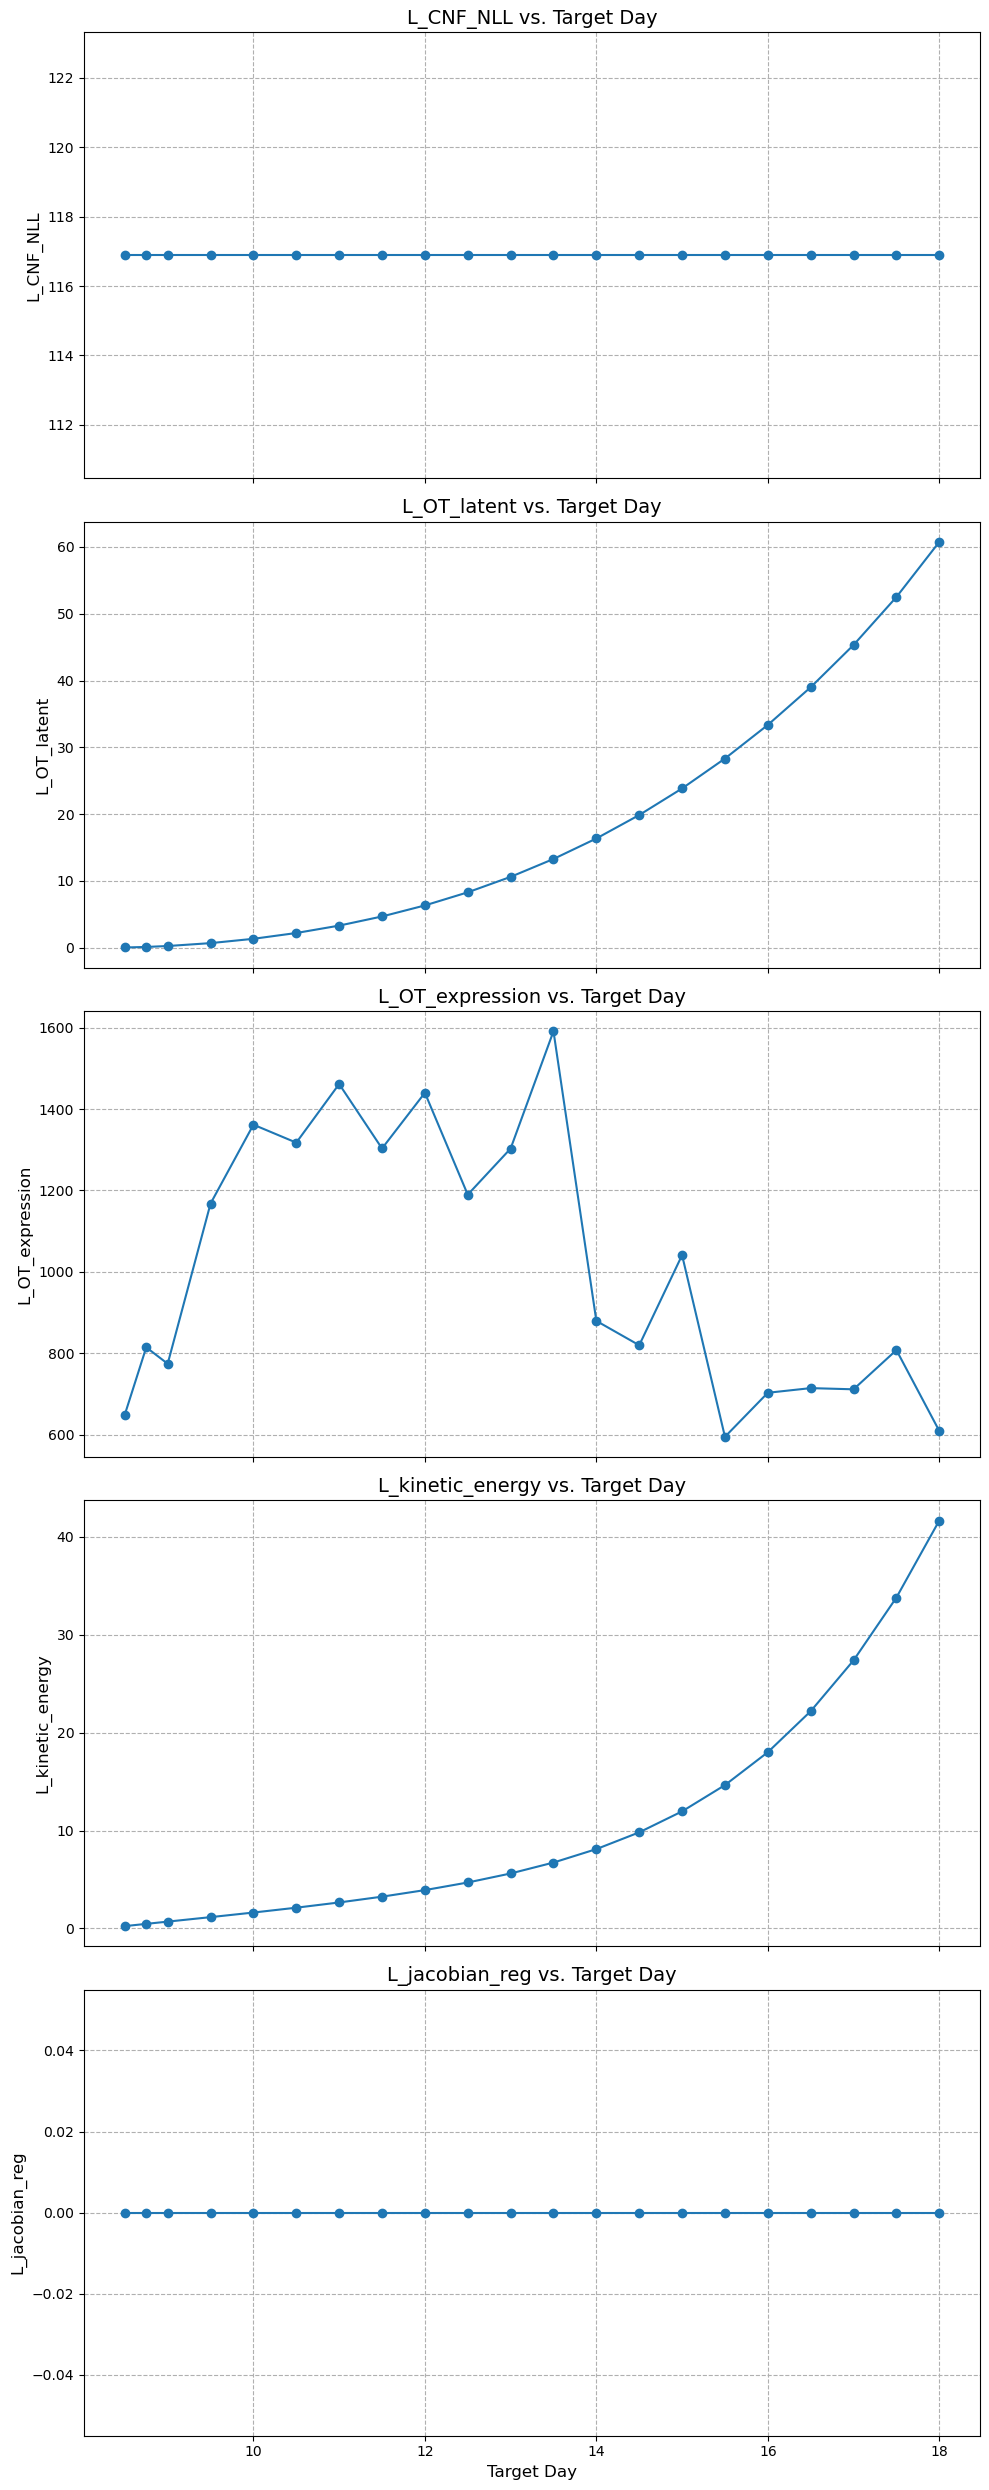

In [6]:
# ## 6. 绘制指标随时间变化的折线图
# --- 绘制折线图 ---
print("\n正在绘制评估指标随时间变化的趋势图...")
metric_keys_to_plot = [key for key, values in filtered_metrics.items() if values and not all(np.isnan(v) for v in values)]
if metric_keys_to_plot:
    fig, axes = plt.subplots(len(metric_keys_to_plot), 1, figsize=(10, 5 * len(metric_keys_to_plot)), sharex=True)
    if len(metric_keys_to_plot) == 1: axes = [axes]

    for ax, key in zip(axes, metric_keys_to_plot):
        ax.plot(days_for_metrics, filtered_metrics[key], marker='o', linestyle='-')
        ax.set_ylabel(key, fontsize=12)
        ax.set_title(f"{key} vs. Target Day", fontsize=14)
        ax.grid(True, linestyle='--')

    axes[-1].set_xlabel("Target Day", fontsize=12)
    plt.tight_layout()
    
    output_dir = config.evaluation_params.get("output_dir", "results/eval_output")
    os.makedirs(output_dir, exist_ok=True)
    plot_filename = os.path.join(output_dir, f"metrics_vs_day_from_{START_DAY}.png")
    plt.savefig(plot_filename, dpi=300)
    print(f"指标趋势图已保存到: {plot_filename}")

    plt.show()
else:
    print("没有有效的指标可以绘制。")

In [7]:
# ## 7. 绘制UMAP结果图
# --- 获取输出目录 ---
output_dir = config.evaluation_params.get("output_dir", "results/eval_output")
os.makedirs(output_dir, exist_ok=True)
print(f"UMAP图将保存到: {output_dir}")

# --- 潜空间绘图 ---
# 图一：预测轨迹 vs. 真实背景 (潜空间)
print("\n正在绘制潜空间对比图 (预测轨迹 vs. 真实背景)...")
comparison_plot_data_latent_v1 = {}
all_real_latent_combined = []
if real_latent_for_umap:
    for data in real_latent_for_umap.values():
        all_real_latent_combined.append(data)
    if all_real_latent_combined:
        comparison_plot_data_latent_v1["Ground Truth (All Days)"] = np.concatenate(all_real_latent_combined, axis=0)
if pred_latent_for_umap:
    comparison_plot_data_latent_v1.update(pred_latent_for_umap)

custom_colors_latent_v1 = ['#dddddd'] 
num_predictions_latent = len(pred_latent_for_umap)
color_map_latent_pred = plt.cm.get_cmap('viridis', num_predictions_latent)
for i in range(num_predictions_latent):
    custom_colors_latent_v1.append(color_map_latent_pred(i))

if "Ground Truth (All Days)" in comparison_plot_data_latent_v1:
    plot_umap_comparison(
        comparison_plot_data_latent_v1,
        output_path=os.path.join(output_dir, f"umap_latent_trajectory_vs_truth.png"),
        title=f"Predicted Trajectory vs. Ground Truth Background in Latent Space",
        colors=custom_colors_latent_v1, point_size=12
    )
    plt.show()

# 图二：真实分布 vs. 预测背景 (潜空间)
print("\n正在绘制潜空间对比图 (真实分布 vs. 预测背景)...")
comparison_plot_data_latent_v2 = {}
all_pred_latent_combined = []
if pred_latent_for_umap:
    for data in pred_latent_for_umap.values():
        all_pred_latent_combined.append(data)
    if all_pred_latent_combined:
        comparison_plot_data_latent_v2["Predicted Trajectory (All Days)"] = np.concatenate(all_pred_latent_combined, axis=0)
if real_latent_for_umap:
    comparison_plot_data_latent_v2.update(real_latent_for_umap)

custom_colors_latent_v2 = ['#dddddd']
num_real_days_latent = len(real_latent_for_umap)
color_map_real_latent = plt.cm.get_cmap('plasma', num_real_days_latent) 
for i in range(num_real_days_latent):
    custom_colors_latent_v2.append(color_map_real_latent(i))

if "Predicted Trajectory (All Days)" in comparison_plot_data_latent_v2:
    plot_umap_comparison(
        comparison_plot_data_latent_v2,
        output_path=os.path.join(output_dir, f"umap_latent_truth_vs_trajectory_background.png"),
        title=f"Ground Truth vs. Predicted Trajectory Background in Latent Space",
        colors=custom_colors_latent_v2, point_size=12
    )
    plt.show()

# --- 表达空间绘图 ---
# 图三：预测轨迹 vs. 真实背景 (表达空间)
print("\n正在绘制表达空间对比图 (预测轨迹 vs. 真实背景)...")
comparison_plot_data_expr_v1 = {}
all_real_expressions_combined = []
if real_expressions_for_umap:
    for data in real_expressions_for_umap.values():
        all_real_expressions_combined.append(data)
    if all_real_expressions_combined:
        comparison_plot_data_expr_v1["Ground Truth (All Days)"] = np.concatenate(all_real_expressions_combined, axis=0)
if pred_expressions_for_umap:
    comparison_plot_data_expr_v1.update(pred_expressions_for_umap)

custom_colors_expr_v1 = ['#dddddd'] 
num_predictions_expr = len(pred_expressions_for_umap)
color_map_expr_pred = plt.cm.get_cmap('viridis', num_predictions_expr)
for i in range(num_predictions_expr):
    custom_colors_expr_v1.append(color_map_expr_pred(i))

if "Ground Truth (All Days)" in comparison_plot_data_expr_v1:
    plot_umap_comparison(
        comparison_plot_data_expr_v1,
        output_path=os.path.join(output_dir, f"umap_expression_trajectory_vs_truth.png"),
        title=f"Predicted Trajectory vs. Ground Truth Background in Expression Space",
        colors=custom_colors_expr_v1, point_size=12
    )
    plt.show()

# 图四：真实分布 vs. 预测背景 (表达空间)
print("\n正在绘制表达空间对比图 (真实分布 vs. 预测背景)...")
comparison_plot_data_expr_v2 = {}
all_pred_expressions_combined = []
if pred_expressions_for_umap:
    for data in pred_expressions_for_umap.values():
        all_pred_expressions_combined.append(data)
    if all_pred_expressions_combined:
        comparison_plot_data_expr_v2["Predicted Trajectory (All Days)"] = np.concatenate(all_pred_expressions_combined, axis=0)
if real_expressions_for_umap:
    comparison_plot_data_expr_v2.update(real_expressions_for_umap)

custom_colors_expr_v2 = ['#dddddd']
num_real_days_expr = len(real_expressions_for_umap)
color_map_real_expr = plt.cm.get_cmap('plasma', num_real_days_expr) 
for i in range(num_real_days_expr):
    custom_colors_expr_v2.append(color_map_real_expr(i))

if "Predicted Trajectory (All Days)" in comparison_plot_data_expr_v2:
    plot_umap_comparison(
        comparison_plot_data_expr_v2,
        output_path=os.path.join(output_dir, f"umap_truth_vs_trajectory_background.png"),
        title=f"Ground Truth vs. Predicted Trajectory Background in Expression Space",
        colors=custom_colors_expr_v2, point_size=12
    )
    plt.show()

print("\n评估完成。")

UMAP图将保存到: results/experiment_default/evaluation_output

正在绘制潜空间对比图 (预测轨迹 vs. 真实背景)...


/tmp/ipykernel_39182/2930488847.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_latent_pred = plt.cm.get_cmap('viridis', num_predictions_latent)
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/root/miniconda3/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP plot saved to results/experiment_default/evaluation_output/umap_latent_trajectory_vs_truth.png

正在绘制潜空间对比图 (真实分布 vs. 预测背景)...


/tmp/ipykernel_39182/2930488847.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_real_latent = plt.cm.get_cmap('plasma', num_real_days_latent)
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP plot saved to results/experiment_default/evaluation_output/umap_latent_truth_vs_trajectory_background.png

正在绘制表达空间对比图 (预测轨迹 vs. 真实背景)...


/tmp/ipykernel_39182/2930488847.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_expr_pred = plt.cm.get_cmap('viridis', num_predictions_expr)
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP plot saved to results/experiment_default/evaluation_output/umap_expression_trajectory_vs_truth.png

正在绘制表达空间对比图 (真实分布 vs. 预测背景)...


/tmp/ipykernel_39182/2930488847.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map_real_expr = plt.cm.get_cmap('plasma', num_real_days_expr)
/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP plot saved to results/experiment_default/evaluation_output/umap_truth_vs_trajectory_background.png

评估完成。
